In [ ]:

import copy, random, gc, time, warnings
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from collections import defaultdict

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Imports successful!")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA: {torch.cuda.is_available()}")


 Imports successful!
PyTorch: 2.8.0+cu126
CUDA: True


In [ ]:

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

CONFIG = {
    'num_clients': 20,
    'client_frac': 0.5,
    'rounds': 20,
    'local_epochs': 5,
    'batch_size': 64,
    'lr': 0.01,
    'dirichlet_alpha': 0.5,
    'model_type': 'smallcnn',

    'fedsam_rho': 0.05,

    'fedscam_rho_max': 0.05,
    'fedscam_alpha_rho': 1.0,
    'fedscam_kappa_h': 1.0,
    'fedscam_beta_global': 0.8,
    'fedscam_gamma_weight': 1.0,
    'fedscam_n_clusters': 3,
    'fedscam_downweight_conflict': 0.5,
    'fedscam_summary_dim': 512,

    'momentum': 0.9,

    'q_param': 0.1,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")
print(f"Model: {CONFIG['model_type']}")
print("Configuration loaded")


Device: cuda
Model: smallcnn
Configuration loaded


In [ ]:

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

def load_dataset(dataset_name='CIFAR10'):
    if dataset_name == 'CIFAR10':
        train_dataset = datasets.CIFAR10('./data', train=True, download=True,
                                        transform=transform_train)
        test_dataset = datasets.CIFAR10('./data', train=False, download=True,
                                       transform=transform_test)
    else:
        train_dataset = datasets.CIFAR100('./data', train=True, download=True,
                                         transform=transform_train)
        test_dataset = datasets.CIFAR100('./data', train=False, download=True,
                                        transform=transform_test)
    return train_dataset, test_dataset

print("Loading datasets...")
train_cifar10, test_cifar10 = load_dataset('CIFAR10')
train_cifar100, test_cifar100 = load_dataset('CIFAR100')
print(f"CIFAR-10: {len(train_cifar10)} train, {len(test_cifar10)} test")
print(f"CIFAR-100: {len(train_cifar100)} train, {len(test_cifar100)} test")


def dirichlet_split(dataset, n_clients, alpha=0.5):
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    n_classes = labels.max() + 1
    client_idxs = [[] for _ in range(n_clients)]

    if alpha == 999:  # IID
        indices = list(range(len(dataset)))
        random.shuffle(indices)
        samples_per_client = len(dataset) // n_clients
        for i in range(n_clients):
            start = i * samples_per_client
            end = start + samples_per_client if i < n_clients - 1 else len(dataset)
            client_idxs[i] = indices[start:end]
    else:  # Non-IID
        for k in range(n_classes):
            idx_k = np.where(labels == k)[0]
            np.random.shuffle(idx_k)
            props = np.random.dirichlet([alpha] * n_clients)
            props = (props * len(idx_k)).astype(int)
            props[-1] = len(idx_k) - props[:-1].sum()
            ptr = 0
            for i, p in enumerate(props):
                if p > 0:
                    client_idxs[i].extend(idx_k[ptr:ptr+p])
                    ptr += p

    return [DataLoader(Subset(dataset, idxs if idxs else [0]),
                      batch_size=CONFIG['batch_size'], shuffle=True,
                      num_workers=0, pin_memory=False)
            for idxs in client_idxs], client_idxs

def plot_client_distribution(client_idxs, dataset, alpha, dataset_name='CIFAR10'):
    labels = np.array([dataset[i][1] for i in range(len(dataset))])
    n_classes = labels.max() + 1

    dist_matrix = np.zeros((CONFIG['num_clients'], n_classes))
    for i, idxs in enumerate(client_idxs):
        for idx in idxs:
            dist_matrix[i, labels[idx]] += 1

    plt.figure(figsize=(14, 6))
    sns.heatmap(dist_matrix.T, cmap='YlOrRd', annot=False,
                cbar_kws={'label': 'Samples'}, linewidths=0.5)
    plt.xlabel('Client ID', fontsize=13, fontweight='bold')
    plt.ylabel('Class ID', fontsize=13, fontweight='bold')

    alpha_str = 'IID' if alpha == 999 else f'α={alpha}'
    plt.title(f'{dataset_name} Client Distribution ({alpha_str})',
              fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("Data partitioning functions")

Loading datasets...


100%|██████████| 170M/170M [00:04<00:00, 34.8MB/s] 
100%|██████████| 169M/169M [00:03<00:00, 49.0MB/s] 


CIFAR-10: 50000 train, 10000 test
CIFAR-100: 50000 train, 10000 test
Data partitioning functions


In [ ]:

class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*8*8, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

class ResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        from torchvision.models import resnet18
        self.model = resnet18(num_classes=num_classes)
        self.model.conv1 = nn.Conv2d(3, 64, 3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()

    def forward(self, x):
        return self.model(x)

def create_model(num_classes=10):
    if CONFIG['model_type'] == 'smallcnn':
        return SmallCNN(num_classes)
    return ResNet18(num_classes)

test_model = create_model(10)
print(f" Model: {CONFIG['model_type']}")
print(f"   Parameters: {sum(p.numel() for p in test_model.parameters()):,}")
del test_model


 Model: smallcnn
   Parameters: 545,098


In [ ]:

class SAM:
    def __init__(self, params, base_opt, rho=0.05):
        self.params = list(params)
        self.optimizer = base_opt(self.params, lr=CONFIG['lr'])
        self.rho = rho

    def zero_grad(self):
        self.optimizer.zero_grad()

    def first_step(self):
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in self.params
                             if p.grad is not None))
        for p in self.params:
            if p.grad is not None:
                eps = self.rho * p.grad / (norm + 1e-12)
                p.data.add_(eps)
                p._eps = eps

    def second_step(self):
        for p in self.params:
            if hasattr(p, '_eps'):
                p.data.sub_(p._eps)
                del p._eps
        self.optimizer.step()

print(" SAM optimizer")


 SAM optimizer


In [ ]:

def state_to_vec(state):
    return np.concatenate([v.detach().cpu().numpy().astype(np.float32).ravel()
                          for v in state.values()])

def vec_to_state(vec, template):
    new = {}
    ptr = 0
    for k, v in template.items():
        n = v.numel()
        new[k] = torch.from_numpy(vec[ptr:ptr+n].reshape(v.shape)).type(v.dtype)
        ptr += n
    return new

def compute_delta(before, after):
    return state_to_vec(after) - state_to_vec(before)

def normalize(vec):
    n = np.linalg.norm(vec)
    return vec / (n + 1e-12) if n > 1e-12 else vec

def clear_mem():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

def evaluate(model, loader):
    model.eval()
    loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss += F.cross_entropy(out, y, reduction='sum').item()
            correct += out.argmax(1).eq(y).sum().item()
            total += y.size(0)
    return loss/total, correct/total

def compute_client_loss(model, loader):
    model.eval()
    loss, total = 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            loss += F.cross_entropy(model(x), y, reduction='sum').item()
            total += y.size(0)
    return loss / total if total > 0 else 0.0

print(" Utility functions")


 Utility functions


In [ ]:

_proj_cache = {}

def random_project(vec, dim):
    key = len(vec)
    if key not in _proj_cache:
        _proj_cache[key] = np.random.randn(dim, key) / np.sqrt(dim)
    return _proj_cache[key] @ vec

def reset_projection():
    global _proj_cache
    _proj_cache = {}


def compute_heterogeneity(model, loader, n_batches=3):
    model.train()
    norms = []
    for i, (x, y) in enumerate(loader):
        if i >= n_batches:
            break
        x, y = x.to(device), y.to(device)
        model.zero_grad()
        F.cross_entropy(model(x), y).backward()
        norm = torch.sqrt(sum(p.grad.norm()**2 for p in model.parameters()
                             if p.grad is not None)).item()
        norms.append(norm)
    return np.mean(norms) if norms else 0.0

def harmonize(deltas, summaries, down, k):
    if len(deltas) <= 1:
        return deltas

    try:
        labels = KMeans(k, random_state=SEED, n_init=10).fit_predict(
            np.stack(summaries))
    except:
        return deltas

    harm = [d.copy() for d in deltas]
    for g in range(k):
        idxs = [i for i, l in enumerate(labels) if l == g]
        if len(idxs) <= 1:
            continue

        for i in idxs:
            for j in idxs:
                if i >= j:
                    continue
                cos = np.dot(harm[i], harm[j]) / (
                    np.linalg.norm(harm[i]) * np.linalg.norm(harm[j]) + 1e-12)
                if cos < 0:
                    if np.linalg.norm(harm[i]) < np.linalg.norm(harm[j]):
                        harm[i] *= down
                    else:
                        harm[j] *= down
    return harm

def fedscam_aggregate(global_state, deltas, h_list, cos_list, sizes):
    base_w = np.array([1/(1 + CONFIG['fedscam_gamma_weight']*h)
                       for h in h_list], dtype=np.float32)
    align_w = np.array([max(0, 1 + CONFIG['fedscam_beta_global']*c)
                        for c in cos_list], dtype=np.float32)
    weights = base_w * align_w
    weights = weights / (weights.sum() + 1e-12)

    agg = sum(d*w for d, w in zip(deltas, weights))
    new_vec = state_to_vec(global_state) + agg
    return vec_to_state(new_vec, global_state)

print(" FedSCAM helpers")


✅ Random projection
 FedSCAM helpers


In [ ]:

def run_fedavg(client_loaders, test_loader, num_classes=10, verbose=True):
    """FedAvg: Baseline federated averaging"""
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes = [], []
        for cid in selected:
            model.load_state_dict(global_state)
            optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)
                    optimizer.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    optimizer.step()

            delta = compute_delta(global_state, model.state_dict())
            deltas.append(delta)
            sizes.append(n_samples)

        weights = np.array(sizes, dtype=np.float32) / sum(sizes)
        agg = sum(d * w for d, w in zip(deltas, weights))
        global_state = vec_to_state(state_to_vec(global_state) + agg, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_fedavgm(client_loaders, test_loader, num_classes=10, verbose=True):
    """FedAvgM: FedAvg with server-side momentum"""
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()
    velocity = np.zeros(len(state_to_vec(global_state)), dtype=np.float32)

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes = [], []
        for cid in selected:
            model.load_state_dict(global_state)
            optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)
                    optimizer.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    optimizer.step()

            delta = compute_delta(global_state, model.state_dict())
            deltas.append(delta)
            sizes.append(n_samples)

        weights = np.array(sizes, dtype=np.float32) / sum(sizes)
        pseudo_grad = -sum(d * w for d, w in zip(deltas, weights))

        velocity = CONFIG['momentum'] * velocity + pseudo_grad
        global_state = vec_to_state(state_to_vec(global_state) - velocity, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_fedsam(client_loaders, test_loader, num_classes=10, verbose=True):
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes = [], []
        for cid in selected:
            model.load_state_dict(global_state)
            before = copy.deepcopy(model.state_dict())
            sam = SAM(model.parameters(), optim.SGD, rho=CONFIG['fedsam_rho'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)

                    sam.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    sam.first_step()

                    sam.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    sam.second_step()

            delta = compute_delta(before, model.state_dict())
            deltas.append(delta)
            sizes.append(n_samples)

        weights = np.array(sizes, dtype=np.float32) / sum(sizes)
        agg = sum(d * w for d, w in zip(deltas, weights))
        global_state = vec_to_state(state_to_vec(global_state) + agg, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_fedlesam(client_loaders, test_loader, num_classes=10, verbose=True):
    """FedLESAM: Locally estimated global perturbations"""
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()
    w_old = None

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes = [], []
        for cid in selected:
            model.load_state_dict(global_state)

            if w_old is not None:
                delta_dir = normalize(state_to_vec(w_old) - state_to_vec(global_state))
            else:
                delta_dir = np.zeros(len(state_to_vec(global_state)), dtype=np.float32)

            delta_state = vec_to_state(CONFIG['fedsam_rho'] * delta_dir, global_state)

            optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)

                    perturbed_state = {}
                    for k in model.state_dict().keys():
                        perturbed_state[k] = model.state_dict()[k] + delta_state[k].to(device)
                    model.load_state_dict(perturbed_state)

                    optimizer.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    optimizer.step()

            delta = compute_delta(global_state, model.state_dict())
            deltas.append(delta)
            sizes.append(n_samples)

        w_old = copy.deepcopy(global_state)

        weights = np.array(sizes, dtype=np.float32) / sum(sizes)
        agg = sum(d * w for d, w in zip(deltas, weights))
        global_state = vec_to_state(state_to_vec(global_state) + agg, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_fedwmsam(client_loaders, test_loader, num_classes=10, verbose=True):
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()
    w_old = None
    momentum_buffer = np.zeros(len(state_to_vec(global_state)), dtype=np.float32)

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes = [], []
        for cid in selected:
            model.load_state_dict(global_state)

            if w_old is not None:
                current_update = state_to_vec(w_old) - state_to_vec(global_state)
                momentum_buffer = CONFIG['momentum'] * momentum_buffer + current_update
                delta_dir = normalize(momentum_buffer)
            else:
                delta_dir = np.zeros(len(state_to_vec(global_state)), dtype=np.float32)

            delta_state = vec_to_state(CONFIG['fedsam_rho'] * delta_dir, global_state)

            optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)

                    perturbed_state = {}
                    for k in model.state_dict().keys():
                        perturbed_state[k] = model.state_dict()[k] + delta_state[k].to(device)
                    model.load_state_dict(perturbed_state)

                    optimizer.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    optimizer.step()

            delta = compute_delta(global_state, model.state_dict())
            deltas.append(delta)
            sizes.append(n_samples)

        w_old = copy.deepcopy(global_state)

        weights = np.array(sizes, dtype=np.float32) / sum(sizes)
        agg = sum(d * w for d, w in zip(deltas, weights))
        global_state = vec_to_state(state_to_vec(global_state) + agg, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_fedlw(client_loaders, test_loader, num_classes=10, verbose=True):
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes, client_losses = [], [], []
        for cid in selected:
            model.load_state_dict(global_state)
            optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)
                    optimizer.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    optimizer.step()

            delta = compute_delta(global_state, model.state_dict())
            client_loss = compute_client_loss(model, client_loaders[cid])

            deltas.append(delta)
            sizes.append(n_samples)
            client_losses.append(client_loss)

        inv_losses = np.array([1.0 / (l + 1e-8) for l in client_losses], dtype=np.float32)
        weights = inv_losses / inv_losses.sum()

        agg = sum(d * w for d, w in zip(deltas, weights))
        global_state = vec_to_state(state_to_vec(global_state) + agg, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_qfedavg(client_loaders, test_loader, num_classes=10, verbose=True):
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, sizes, client_losses = [], [], []
        for cid in selected:
            model.load_state_dict(global_state)
            optimizer = optim.SGD(model.parameters(), lr=CONFIG['lr'])
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)
                    optimizer.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    optimizer.step()

            delta = compute_delta(global_state, model.state_dict())
            client_loss = compute_client_loss(model, client_loaders[cid])

            deltas.append(delta)
            sizes.append(n_samples)
            client_losses.append(client_loss)

        q = CONFIG['q_param']
        loss_weights = np.array([l**q for l in client_losses], dtype=np.float32)
        weights = loss_weights / loss_weights.sum()

        agg = sum(d * w for d, w in zip(deltas, weights))
        global_state = vec_to_state(state_to_vec(global_state) + agg, global_state)

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def run_fedscam(client_loaders, test_loader, num_classes=10, verbose=True):
    model = create_model(num_classes).to(device)
    global_state = model.state_dict()
    prev_global = None

    accs, losses, times = [], [], []
    start_time = time.time()

    for r in range(1, CONFIG['rounds']+1):
        round_start = time.time()

        m = max(1, int(CONFIG['client_frac'] * CONFIG['num_clients']))
        selected = random.sample(range(CONFIG['num_clients']), m)

        deltas, summaries, h_adjs, coss, sizes = [], [], [], [], []

        for cid in selected:
            temp = create_model(num_classes).to(device)
            temp.load_state_dict(global_state)
            h = compute_heterogeneity(temp, client_loaders[cid], n_batches=3)

            rho_p = 0.5 * CONFIG['fedscam_rho_max'] / (
                1 + CONFIG['fedscam_alpha_rho'] * h)

            temp.load_state_dict(global_state)
            before = copy.deepcopy(temp.state_dict())
            sam_pilot = SAM(temp.parameters(), optim.SGD, rho=rho_p)

            try:
                x, y = next(iter(client_loaders[cid]))
                x, y = x.to(device), y.to(device)
                sam_pilot.zero_grad()
                F.cross_entropy(temp(x), y).backward()
                sam_pilot.first_step()
                sam_pilot.zero_grad()
                F.cross_entropy(temp(x), y).backward()
                sam_pilot.second_step()

                delta_pilot = compute_delta(before, temp.state_dict())
                pilot = random_project(normalize(delta_pilot),
                                      CONFIG['fedscam_summary_dim'])
            except:
                pilot = np.zeros(CONFIG['fedscam_summary_dim'])

            if prev_global is not None:
                cos = np.clip(np.dot(normalize(pilot), prev_global) / (
                    np.linalg.norm(normalize(pilot)) *
                    np.linalg.norm(prev_global) + 1e-12), -1, 1)
            else:
                cos = 0.0

            h_adj = h * max(0, 1 - CONFIG['fedscam_kappa_h'] * cos)

            rho = CONFIG['fedscam_rho_max'] / (
                1 + CONFIG['fedscam_alpha_rho'] * h_adj)

            model.load_state_dict(global_state)
            before = copy.deepcopy(model.state_dict())
            sam = SAM(model.parameters(), optim.SGD, rho=rho)
            model.train()

            n_samples = 0
            for _ in range(CONFIG['local_epochs']):
                for x, y in client_loaders[cid]:
                    x, y = x.to(device), y.to(device)
                    n_samples += x.size(0)
                    sam.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    sam.first_step()
                    sam.zero_grad()
                    F.cross_entropy(model(x), y).backward()
                    sam.second_step()

            delta = compute_delta(before, model.state_dict())
            summary = random_project(normalize(delta),
                                    CONFIG['fedscam_summary_dim'])

            deltas.append(delta)
            summaries.append(summary)
            h_adjs.append(h_adj)
            coss.append(cos)
            sizes.append(n_samples)

        harm = harmonize(deltas, summaries,
                        CONFIG['fedscam_downweight_conflict'],
                        min(CONFIG['fedscam_n_clusters'], len(deltas)))

        global_state = fedscam_aggregate(global_state, harm, h_adjs,
                                         coss, sizes)

        prev_global = normalize(random_project(state_to_vec(global_state),
                                              CONFIG['fedscam_summary_dim']))

        clear_mem()

        model.load_state_dict(global_state)
        loss, acc = evaluate(model, test_loader)
        losses.append(loss)
        accs.append(acc)

        round_time = time.time() - round_start
        times.append(round_time)

        if verbose:
            print(f"Round {r:2d} | Acc: {acc:.4f} | Loss: {loss:.4f} | Time: {round_time:.2f}s")

    total_time = time.time() - start_time
    return {'accs': accs, 'losses': losses, 'times': times, 'total_time': total_time}


In [ ]:

def plot_individual_algorithm(results_dict, alg_name, dataset_name, alphas):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    colors = ['#E63946', '#F77F00', '#06A77D']
    markers = ['o', 's', '^']

    for idx, alpha in enumerate(alphas):
        key = f'alpha_{alpha}'
        if key in results_dict:
            rounds = range(1, CONFIG['rounds']+1)
            alpha_str = 'IID' if alpha == 999 else f'α={alpha}'

            ax1.plot(rounds, results_dict[key]['accs'], label=alpha_str,
                    color=colors[idx], marker=markers[idx], markevery=5,
                    linewidth=2.5, markersize=7, alpha=0.85)
            ax2.plot(rounds, results_dict[key]['losses'], label=alpha_str,
                    color=colors[idx], marker=markers[idx], markevery=5,
                    linewidth=2.5, markersize=7, alpha=0.85)

    ax1.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Test Accuracy', fontsize=12, fontweight='bold')
    ax1.set_title(f'{alg_name}: Accuracy', fontsize=13, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3, linestyle='--')

    ax2.set_xlabel('Round', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Test Loss', fontsize=12, fontweight='bold')
    ax2.set_title(f'{alg_name}: Loss', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3, linestyle='--')

    plt.suptitle(f'{alg_name} on {dataset_name}', fontsize=15, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_final_accuracy_comparison(all_results, dataset_name, alphas):
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    x = np.arange(len(alphas))
    width = 0.1
    alg_names = list(all_results.keys())
    colors = plt.cm.tab10(np.linspace(0, 1, len(alg_names)))

    for i, alg_name in enumerate(alg_names):
        final_accs = []
        for alpha in alphas:
            key = f'alpha_{alpha}'
            if key in all_results[alg_name]:
                final_accs.append(all_results[alg_name][key]['accs'][-1])
            else:
                final_accs.append(0)

        offset = (i - len(alg_names)/2) * width
        bars = ax.bar(x + offset, final_accs, width, label=alg_name,
                     color=colors[i], alpha=0.8, edgecolor='black', linewidth=1.2)

        for bar in bars:
            height = bar.get_height()
            if height > 0:
                ax.text(bar.get_x() + bar.get_width()/2., height,
                       f'{height:.3f}', ha='center', va='bottom', fontsize=8)

    alpha_labels = ['α=0.1\n(High Non-IID)', 'α=0.5\n(Medium Non-IID)', 'IID']
    ax.set_xlabel('Data Distribution', fontsize=13, fontweight='bold')
    ax.set_ylabel('Final Test Accuracy', fontsize=13, fontweight='bold')
    ax.set_title(f'Final Accuracy Comparison: {dataset_name}',
                 fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(alpha_labels)
    ax.legend(fontsize=9, ncol=2)
    ax.grid(True, alpha=0.3, axis='y', linestyle='--')

    plt.tight_layout()
    plt.show()

def plot_combined_comparison(all_results, dataset_name, alpha):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    rounds = range(1, CONFIG['rounds']+1)
    colors = plt.cm.tab10(np.linspace(0, 1, len(all_results)))
    markers = ['o', 's', '^', 'D', 'v', '<', '>', 'p']

    key = f'alpha_{alpha}'

    for idx, (alg_name, results) in enumerate(all_results.items()):
        if key not in results:
            continue

        ax1.plot(
            rounds, results[key]['accs'],
            label=alg_name,
            color=colors[idx],
            marker=markers[idx % len(markers)],
            markevery=5,
            linewidth=2
        )

        ax2.plot(
            rounds, results[key]['losses'],
            label=alg_name,
            color=colors[idx],
            marker=markers[idx % len(markers)],
            markevery=5,
            linewidth=2
        )

    alpha_str = 'IID' if alpha == 999 else f'α={alpha}'

    ax1.set_title(f'Accuracy Comparison ({alpha_str})', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Round')
    ax1.set_ylabel('Test Accuracy')
    ax1.legend(fontsize=9)
    ax1.grid(True, alpha=0.3)

    ax2.set_title(f'Loss Comparison ({alpha_str})', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Round')
    ax2.set_ylabel('Test Loss')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3)

    plt.suptitle(f'Combined Algorithm Comparison on {dataset_name}',
                 fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.show()


In [ ]:

def visualize_results(dataset_name):
    print(f"\n VISUALIZING RESULTS: {dataset_name}")

    for alg in ALL_RESULTS.keys():
        plot_individual_algorithm(
            ALL_RESULTS[alg],
            alg,
            dataset_name,
            ALPHAS
        )

    plot_final_accuracy_comparison(ALL_RESULTS, dataset_name, ALPHAS)

    for alpha in ALPHAS:
        plot_combined_comparison(ALL_RESULTS, dataset_name, alpha)


#visualize_results("CIFAR-10")

In [ ]:

ALPHAS = [0.1]

ALL_RESULTS = {
    'FedAvg': {},
    'FedAvgM': {},
    'FedSAM': {},
    'FedLESAM': {},
    'FedWMSAM': {},
    'FedLW': {},
    'qFedAvg': {},
    'FedSCAM': {},
}
dataset_name = 'CIFAR-10'
train_dataset = train_cifar10
test_dataset = test_cifar10


print(f"\n{'='*80}")
print(f"RUNNING EXPERIMENTS ON {dataset_name}")
print(f"{'='*80}")
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

for alpha in ALPHAS:
    print(f"\n--- Alpha = {alpha} ---")
    CONFIG['dirichlet_alpha'] = alpha

    client_loaders, client_idxs = dirichlet_split(
        train_dataset,
        CONFIG['num_clients'],
        alpha
    )




RUNNING EXPERIMENTS ON CIFAR-10

--- Alpha = 0.1 ---


In [ ]:
print(f"\n{'='*80}")
print(f"FedSCAM")
print(f"{'='*80}")
reset_projection()
ALL_RESULTS['FedSCAM'][f'alpha_{alpha}'] = run_fedscam(
    client_loaders, test_loader, verbose=True)

In [ ]:
print(f"\n{'='*80}")
print(f"FedSAM")
print(f"{'='*80}")
ALL_RESULTS['FedSAM'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)


In [ ]:
print(f"\n{'='*80}")
print(f"FedLESAM")
print(f"{'='*80}")
ALL_RESULTS['FedLESAM'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)

In [ ]:
print(f"\n{'='*80}")
print(f"FedAvg")
print(f"{'='*80}")
ALL_RESULTS['FedAvg'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)

In [ ]:
print(f"\n{'='*80}")
print(f"FedAvgM")
print(f"{'='*80}")
ALL_RESULTS['FedAvgM'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)

In [ ]:
print(f"\n{'='*80}")
print(f"FedWMSAM")
print(f"{'='*80}")
ALL_RESULTS['FedWMSAM'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)

In [ ]:
print(f"\n{'='*80}")
print(f"FedLW")
print(f"{'='*80}")
ALL_RESULTS['FedLW'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)

In [ ]:
print(f"\n{'='*80}")
print(f"qFedAvg")
print(f"{'='*80}")
ALL_RESULTS['qFedAvg'][f'alpha_{alpha}'] = run_fedsam(
    client_loaders, test_loader, verbose=True)
clear_mem()

In [ ]:
visualize_results("CIFAR-10")

In [ ]:
plot_client_distribution(client_idxs, train_dataset, alpha, dataset_name)

### FEDSCAM ABLATION

In [ ]:

ablations = {
    #'fedscam_rho_max': [0.01, 0.05, 0.1],
    'fedscam_beta_global': [0.0, 0.8, 2.0],
    #'fedscam_gamma_weight': [0.0, 1.0, 5.0],
    #'fedscam_kappa_h': [0.0, 0.5, 1.0],
}
alpha=0.1

for param, values in ablations.items():
    results = {}
    CONFIG['dirichlet_alpha'] = alpha

    client_loaders, _ = dirichlet_split(
        train_cifar10, CONFIG['num_clients'], alpha
    )
    test_loader = DataLoader(test_cifar10, batch_size=256)

    for v in svalue:
        param_name = param
        reset_projection()
        print(f"Running FedSCAM with {param_name}={v}")
        res = run_fedscam(client_loaders, test_loader, verbose=True)
        results[v] = res
    plot_fedscam_ablation(res, param)

In [23]:
import os
import matplotlib.pyplot as plt

def save_gamma_accuracy_rounds(results, save_path="beta_acc_vs_rounds.png"):
    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)

    plt.figure(figsize=(9, 6))
    rounds = range(1, len(next(iter(results.values()))['accs']) + 1)

    for beta, res in sorted(results.items()):
        plt.plot(
            rounds,
            res['accs'],
            marker='o',
            linewidth=2,
            label=f"β={beta}"
        )

    plt.xlabel("Communication Round")
    plt.ylabel("Test Accuracy")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()


In [ ]:



def save_gamma_final_accuracy(results, save_path="beta_final_accuracy.png"):
    import numpy as np
    import os
    import matplotlib.pyplot as plt

    os.makedirs(os.path.dirname(save_path) or ".", exist_ok=True)

    betas = sorted(results.keys())
    final_accs = [results[g]['accs'][-1] for g in betas]

    x = np.arange(len(betas)) 

    plt.figure(figsize=(7, 5))
    plt.bar(x, final_accs)

    plt.xticks(x, [str(g) for g in betas])
    plt.xlabel("β")
    plt.ylabel("Final Test Accuracy")

    plt.grid(True, axis="y", linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300)
    plt.show()
    plt.close()





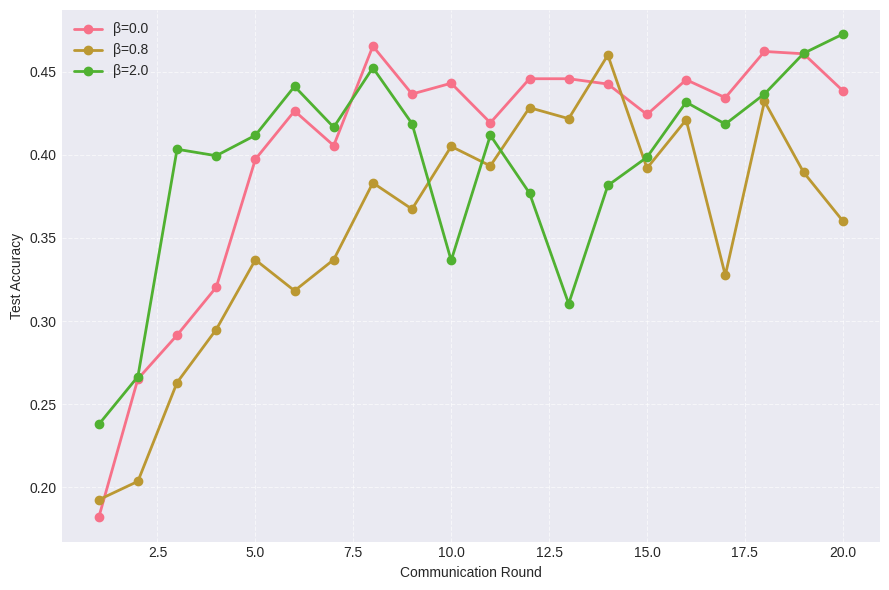

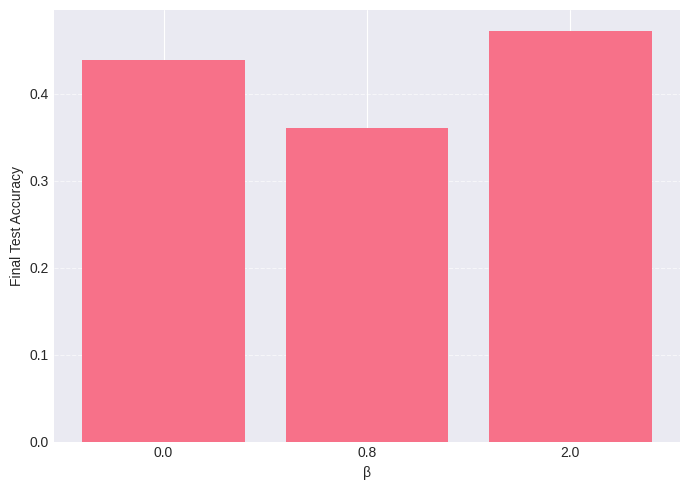

In [25]:
save_beta_accuracy_rounds(results, "figs/beta_acc_rounds.png")
save_beta_final_accuracy(results, "figs/beta_final_acc.png")
